In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (10, 6)
import warnings
warnings.filterwarnings('ignore')

In [9]:
posts_df = pd.read_csv("../output/posts_feature_engineered.csv")

In [17]:
print(posts_df.shape)
posts_df.head()

(11208, 13)


,id,subreddit.name,topic,score,log_score,title_length,selftext_length,total_text_length,log_text_length,hour,dayofweek,is_weekend,segment
0,t4f9bf,datasets,1,7,2.079442,21,9,30,3.433987,18,1,0,2
1,t4euxw,datasets,32,1,0.693147,89,522,611,6.416732,18,1,0,0
2,t4e0bb,datasets,1,1,0.693147,45,9,54,4.007333,18,1,0,2
3,t49fq0,datasets,153,1,0.693147,42,177,219,5.393628,14,1,0,0
4,t47wiw,datasets,6,2,1.098612,79,123,202,5.313206,13,1,0,2


In [18]:
segment_features = posts_df[[
    'topic',
    'log_score',
    'log_text_length',
    'hour',
    'is_weekend'
]]


In [19]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(segment_features)

#### K 후보 탐색 (Elbow + Silhouette)

In [20]:
ks = range(2, 9)
inertias = []
sil_scores = []

for k in ks:
    kmeans = KMeans(
        n_clusters=k,
        random_state=42,
        n_init=10
    )
    labels = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))


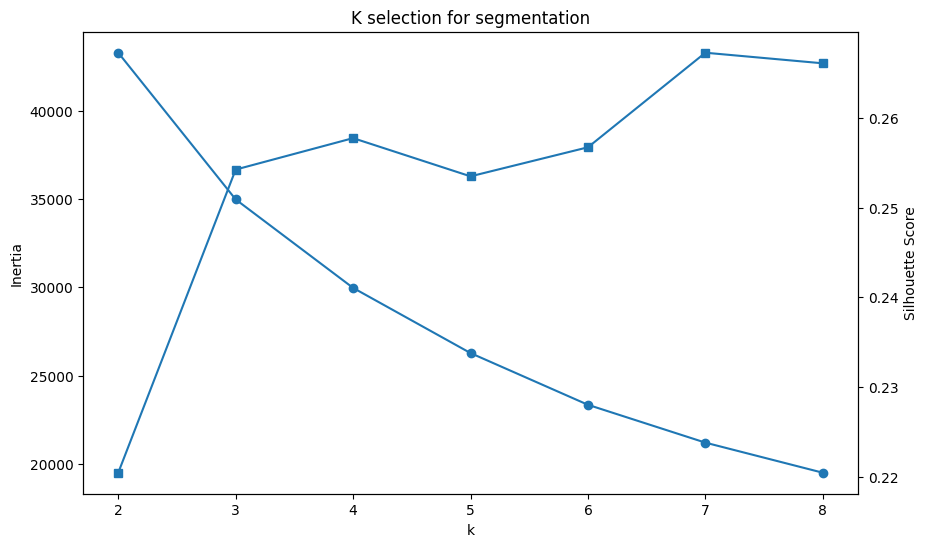

In [21]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(ks, inertias, marker='o')
ax2.plot(ks, sil_scores, marker='s')

ax1.set_xlabel("k")
ax1.set_ylabel("Inertia")
ax2.set_ylabel("Silhouette Score")
plt.title("K selection for segmentation")
plt.show()

In [23]:
FINAL_K = 4

kmeans = KMeans(n_clusters=FINAL_K,
    random_state=42, n_init=20
)

posts_df['segment'] = kmeans.fit_predict(X_scaled)


In [24]:
segment_summary = posts_df.groupby('segment').agg({
    'topic': 'mean',
    'score': 'mean',
    'title_length': 'mean',
    'selftext_length': 'mean',
    'total_text_length': 'mean',
    'hour': 'mean',
    'id': 'count'
}).rename(columns={'id': 'num_posts'}).reset_index()

segment_summary

,segment,topic,score,title_length,selftext_length,total_text_length,hour,num_posts
0,0,16.082373,6.092190,55.434059,227.808365,283.242424,12.964575,2343
1,1,3.404537,1.762355,53.892790,26.151229,80.044018,12.827167,3703
2,2,21.102240,9.632395,57.404940,473.603676,531.008616,12.753303,3482
3,3,103.047619,7.129167,52.042262,395.185714,447.227976,12.769048,1680


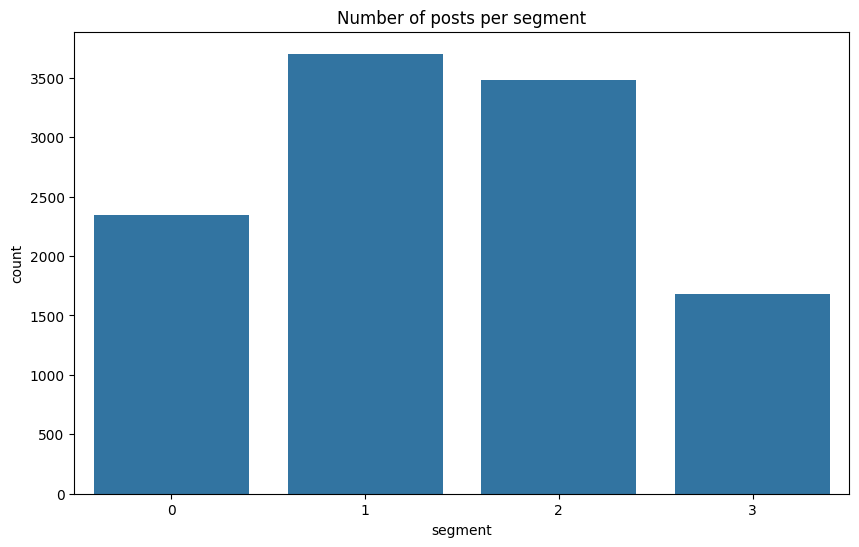

In [25]:
sns.countplot(x='segment', data=posts_df)
plt.title("Number of posts per segment")
plt.show()

In [26]:
segment_topic = (
    posts_df
    .groupby(['segment', 'topic'])
    .size()
    .reset_index(name='count')
)


In [27]:
segment_topic_ratio = (
    segment_topic
    .assign(
        ratio=lambda x: x['count'] /
        x.groupby('segment')['count'].transform('sum')
    )
)

segment_topic_ratio.head()

,segment,topic,count,ratio
0,0,0,572,0.244131
1,0,1,424,0.180965
2,0,2,91,0.038839
3,0,3,51,0.021767
4,0,4,47,0.020060


In [28]:
top_topics = (
    posts_df['topic']
    .value_counts()
    .head(10)
    .index
)

segment_topic_top = segment_topic_ratio[
    segment_topic_ratio['topic'].isin(top_topics)
]


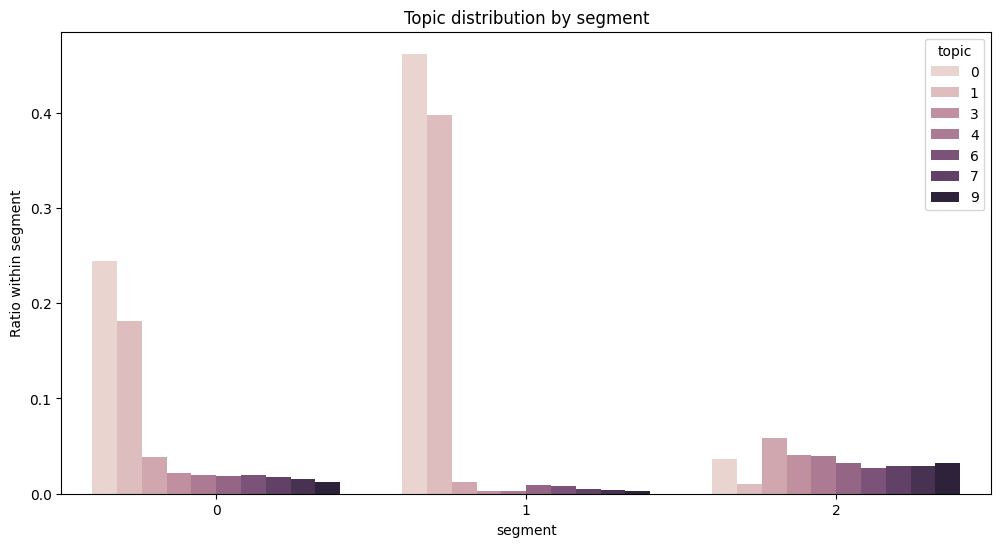

In [29]:
plt.figure(figsize=(12, 6))
sns.barplot(
    data=segment_topic_top,
    x='segment',
    y='ratio',
    hue='topic'
)
plt.title("Topic distribution by segment")
plt.ylabel("Ratio within segment")
plt.show()

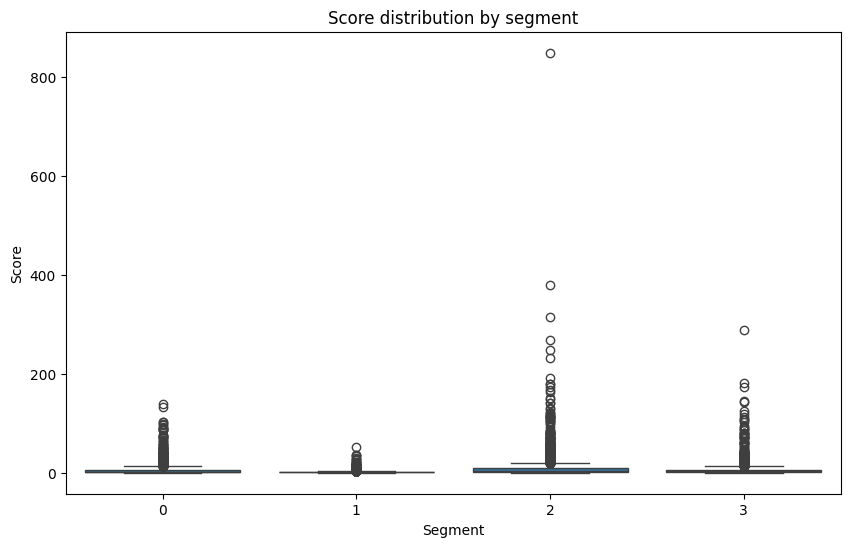

In [30]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=posts_df,
    x='segment',
    y='score'
)
plt.title("Score distribution by segment")
plt.xlabel("Segment")
plt.ylabel("Score")
plt.show()

In [31]:
segment_score_summary = (
    posts_df
    .groupby('segment')
    .agg(
        mean_score=('score', 'mean'),
        median_score=('score', 'median'),
        std_score=('score', 'std'),
        num_posts=('id', 'count')
    )
    .reset_index()
)

segment_score_summary

,segment,mean_score,median_score,std_score,num_posts
0,0,6.092190,2.0,11.545441,2343
1,1,1.762355,1.0,2.577218,3703
2,2,9.632395,4.0,24.100404,3482
3,3,7.129167,3.0,16.521233,1680


In [32]:
representative_posts = (
    posts_df
    .sort_values(['segment', 'score'], ascending=[True, False])
    .groupby('segment')
    .head(3)
    .loc[:, [
        'segment',
        'id',
        'subreddit.name',
        'topic',
        'score',
        'title_length',
        'selftext_length',
        'hour'
    ]]
)

representative_posts

,segment,id,subreddit.name,topic,score,title_length,selftext_length,hour
189,0,sa9vuu,datasets,55,139,68,963,19
3102,0,if9wgx,datasets,19,133,134,472,19
2389,0,kh4poa,datasets,24,103,129,536,23
5655,1,cdvrja,datasets,1,53,17,9,11
6607,1,a7bj5u,datasets,0,36,16,9,14
908,1,paubt7,datasets,1,35,17,9,19
10105,2,3bxlg7,datasets,3,849,126,5436,0
4587,2,exnzrd,datasets,5,380,20,2151,12
5595,2,cjdxhz,datasets,7,314,63,1229,16
4591,3,excg1h,datasets,75,289,47,731,20
